In [58]:
# Imports

import pandas as pd
import numpy as np

import geopandas as gpd
from shapely.geometry import Point, LineString
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
# import geopy.distance

In [3]:
# Load nl_cities dataset

nl_cities = pd.read_csv('./nl_cities.csv')

print(nl_cities.head())
print(nl_cities.shape)

        city      lat     lng      country iso2     admin_name  capital  \
0  The Hague  52.0767  4.2986  Netherlands   NL   Zuid-Holland  primary   
1  Amsterdam  52.3667  4.8833  Netherlands   NL  Noord-Holland  primary   
2    Utrecht  52.0908  5.1222  Netherlands   NL        Utrecht    admin   
3  Rotterdam  51.9225  4.4792  Netherlands   NL   Zuid-Holland    minor   
4  Eindhoven  51.4408  5.4778  Netherlands   NL  Noord-Brabant    minor   

   population  population_proper  
0   1406000.0           501725.0  
1    862965.0           862965.0  
2    640000.0           316448.0  
3    631155.0           631155.0  
4    398053.0           209620.0  
(944, 9)


In [4]:
nl_cities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 944 entries, 0 to 943
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   city               944 non-null    object 
 1   lat                944 non-null    float64
 2   lng                944 non-null    float64
 3   country            944 non-null    object 
 4   iso2               944 non-null    object 
 5   admin_name         941 non-null    object 
 6   capital            410 non-null    object 
 7   population         787 non-null    float64
 8   population_proper  787 non-null    float64
dtypes: float64(4), object(5)
memory usage: 66.5+ KB


In [5]:
# Null-values

# Columns admin_name, capital, population, population_proper have some null-values  

# Capital has the most number of null-values.
# We keep all the rows in the column but do not delete it since it is not a necessary column but can help later with choosing cities.

In [6]:
# admin_name only has three nan values.
# Looking at the rows, all three are cities in the caribbean that belong to the Netherlands, so we delete them.
# (they are connected by sea so we wouldn't be able to 'travel' there)

nl_cities[nl_cities["admin_name"].isna()]

,city,lat,lng,country,iso2,admin_name,capital,population,population_proper
673,Oranjestad,17.4833,-62.9833,Netherlands,NL,NaN,admin,1021.0,1021.0
749,The Bottom,17.6261,-63.2492,Netherlands,NL,NaN,admin,495.0,495.0
798,Kralendijk,12.1517,-68.2761,Netherlands,NL,NaN,admin,NaN,NaN


In [7]:
nl_cities.dropna(subset = ["admin_name"], inplace = True)

In [8]:
nl_cities.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 941 entries, 0 to 943
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   city               941 non-null    object 
 1   lat                941 non-null    float64
 2   lng                941 non-null    float64
 3   country            941 non-null    object 
 4   iso2               941 non-null    object 
 5   admin_name         941 non-null    object 
 6   capital            407 non-null    object 
 7   population         785 non-null    float64
 8   population_proper  785 non-null    float64
dtypes: float64(4), object(5)
memory usage: 73.5+ KB


In [9]:
# population and population_proper have the same number of null-values.
# We can delete those rows because if they are from the same row, we are still left with 785 rows.
# (Two were common with admin_name)

nl_cities.dropna(subset = ["population", "population_proper"], inplace = True)

# After deleting them, we are left with 785 rows so they are from the same rows.

nl_cities.shape

(785, 9)

In [10]:
# Columns to delete

# Column country & iso2 is not necessary, as all cities are Dutch.
# The rest we keep for the reasons above.

nl_cities.drop(columns = ["country", "iso2"], axis = 1, inplace = True)

In [12]:
# Distribution of different columns

# We make a geopandas map of the cities included in the dataframe.

# Load NL map divided per province.
mapnl = gpd.read_file("https://stacks.stanford.edu/file/druid:st293bj4601/data.zip")

mapnl = mapnl[["NAME_1", "TYPE_1", "geometry"]]

print(mapnl.head(1))

    NAME_1     TYPE_1                                           geometry
0  Drenthe  Provincie  POLYGON ((6.50131 53.19841, 6.50429 53.19749, ...


In [13]:
# make our longitude and latitude columns from nl_cities into geometry coordinates

crs = {'init':'EPSG:4326'}
geometry = [Point(xy) for xy in zip(nl_cities['lng'], nl_cities['lat'])]
geo_nl_cities = gpd.GeoDataFrame(nl_cities.copy(), 
                          crs = crs,
                          geometry = geometry)

print(geo_nl_cities.head(1))

        city      lat     lng    admin_name  capital  population  \
0  The Hague  52.0767  4.2986  Zuid-Holland  primary   1406000.0   

   population_proper                  geometry  
0           501725.0  POINT (4.29860 52.07670)  


/home/nskor/Hardness-of-ATSP/.venv/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


/home/nskor/Hardness-of-ATSP/.venv/lib/python3.10/site-packages/geopandas/plotting.py:656: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


Text(0.5, 1.0, 'Cities in the Netherlands population heatmap')

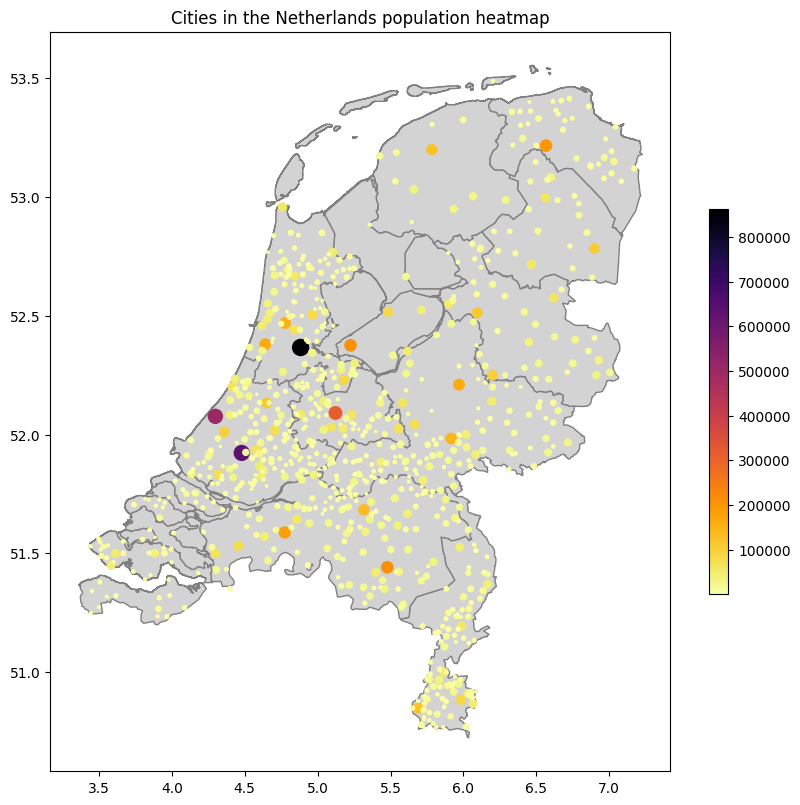

In [14]:
import math
# Plot cities on the map
# Each marker's color and size shows population_proper

fig, ax = plt.subplots(figsize = (10, 10))
mapnl.plot(column = "NAME_1", edgecolor="grey", ax = ax, color = 'lightgrey')

geo_nl_cities['marker_size'] = np.sqrt(geo_nl_cities['population_proper']) / 7

geo_nl_cities.plot(column = 'population_proper', cmap = "inferno_r", ax = ax, legend = True, legend_kwds={'shrink': 0.5}, 
            markersize = 'marker_size')

ax.set_title('Cities in the Netherlands population heatmap')

In [34]:
# Create instances of 10, 20, 30, ..., 100 biggest Dutch cities by population

dict = {}

for i in range(10, 110, 10):
    dict[i] = geo_nl_cities.sort_values(['population_proper'], ascending = False).head(i)
    dict[i].set_index("city", drop = True, inplace = True)

In [52]:
# Create distance matrix

dict_2 = {}

for i in range(10, 110, 10):
    # Create diagonal matrix
    dict_2[i] = pd.DataFrame(np.diag(dict[i]["geometry"]), columns=dict[i].index, index=dict[i].index)
    
    # Add distance between each city
    for city1 in dict_2[i].index:
        for city2 in dict_2[i].index:
            if city1 != city2:
                dict_2[i][city1][city2] = dict[i]["geometry"][city1].distance(dict[i]["geometry"][city2])
    
    # Set the diagonal (same city) to inf
    for city1, city2 in zip(dict_2[i].index, dict_2[i].index):
        dict_2[i][city1][city2] = np.inf

In [53]:
dict_2[10]

city,Amsterdam,Rotterdam,The Hague,Utrecht,Eindhoven,Almere,Groningen,Breda,Apeldoorn,Haarlem
city,,,,,,,,,,
Amsterdam,inf,0.600508,0.652667,0.364958,1.100328,0.342421,1.885825,0.78669,1.09794,0.243081
Rotterdam,0.600508,inf,0.237474,0.664661,1.10871,0.873266,2.456137,0.446903,1.518269,0.485418
The Hague,0.652667,0.237474,inf,0.823721,1.339732,0.974058,2.538479,0.682842,1.676707,0.457315
Utrecht,0.364958,0.664661,0.823721,inf,0.740913,0.303177,1.831456,0.61144,0.856139,0.561915
Eindhoven,1.100328,1.10871,1.339732,0.740913,inf,0.968416,2.083152,0.717948,0.913197,1.258397
Almere,0.342421,0.873266,0.974058,0.303177,0.968416,inf,1.582928,0.907996,0.762641,0.585017
Groningen,1.885825,2.456137,2.538479,1.831456,2.083152,1.582928,inf,2.421669,1.170255,2.099863
Breda,0.78669,0.446903,0.682842,0.61144,0.717948,0.907996,2.421669,inf,1.347417,0.804111
Apeldoorn,1.09794,1.518269,1.676707,0.856139,0.913197,0.762641,1.170255,1.347417,inf,1.340264


In [ ]:
# Implement Little's algorithm on the 10 matrices



In [25]:
# Can use the largest markers for each province as an instance.

# Create new dataframe geo_nl_cities_max that 

geo_nl_cities_max = geo_nl_cities[geo_nl_cities["population_proper"] == geo_nl_cities.groupby("admin_name")["population_proper"].transform('max')]

geo_nl_cities_max

,city,lat,lng,admin_name,capital,population,population_proper,geometry,marker_size
1,Amsterdam,52.3667,4.8833,Noord-Holland,primary,862965.0,862965.0,POINT (4.88330 52.36670),132.708442
2,Utrecht,52.0908,5.1222,Utrecht,admin,640000.0,316448.0,POINT (5.12220 52.09080),80.362444
3,Rotterdam,51.9225,4.4792,Zuid-Holland,minor,631155.0,631155.0,POINT (4.47920 51.92250),113.493235
4,Eindhoven,51.4408,5.4778,Noord-Brabant,minor,398053.0,209620.0,POINT (5.47780 51.44080),65.406110
5,Almere,52.3758,5.2256,Flevoland,minor,207904.0,207904.0,POINT (5.22560 52.37580),65.137844
6,Groningen,53.2167,6.5667,Groningen,admin,201462.0,201462.0,POINT (6.56670 53.21670),64.120741
8,Apeldoorn,52.2100,5.9700,Gelderland,minor,161156.0,161156.0,POINT (5.97000 52.21000),57.348914
13,Leeuwarden,53.2000,5.7833,Fryslân,admin,124084.0,124084.0,POINT (5.78330 53.20000),50.322227
14,Maastricht,50.8483,5.6889,Limburg,admin,122378.0,122378.0,POINT (5.68890 50.84830),49.975096
15,Zwolle,52.5125,6.0944,Overijssel,admin,111805.0,111805.0,POINT (6.09440 52.51250),47.767507


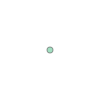

In [26]:
geo_nl_cities_max.iloc[0]["geometry"]

In [15]:
geo_nl_cities_max.shape

(12, 9)

In [27]:
# Sort cities manually so we get a nice cycle (just for visualization purposes)

sort_dict = {"Amsterdam": 0,
             "Almere": 1,
             "Leeuwarden": 2,
             "Groningen": 3,
             "Emmen": 4,
             "Zwolle": 5,
             "Apeldoorn": 6,
             "Eindhoven": 7,
             "Maastricht": 8,
             "Middelburg": 9,
             "Rotterdam": 10,
             "Utrecht": 11}

geo_nl_cities_max = geo_nl_cities_max.sort_values(by = 'city', key = (lambda x: x.map(sort_dict)))

geo_nl_cities_max = geo_nl_cities_max.reset_index(drop = True)

geo_nl_cities_max

,city,lat,lng,admin_name,capital,population,population_proper,geometry,marker_size
0,Amsterdam,52.3667,4.8833,Noord-Holland,primary,862965.0,862965.0,POINT (4.88330 52.36670),132.708442
1,Almere,52.3758,5.2256,Flevoland,minor,207904.0,207904.0,POINT (5.22560 52.37580),65.137844
2,Leeuwarden,53.2000,5.7833,Fryslân,admin,124084.0,124084.0,POINT (5.78330 53.20000),50.322227
3,Groningen,53.2167,6.5667,Groningen,admin,201462.0,201462.0,POINT (6.56670 53.21670),64.120741
4,Emmen,52.7833,6.9000,Drenthe,minor,107471.0,107471.0,POINT (6.90000 52.78330),46.832528
5,Zwolle,52.5125,6.0944,Overijssel,admin,111805.0,111805.0,POINT (6.09440 52.51250),47.767507
6,Apeldoorn,52.2100,5.9700,Gelderland,minor,161156.0,161156.0,POINT (5.97000 52.21000),57.348914
7,Eindhoven,51.4408,5.4778,Noord-Brabant,minor,398053.0,209620.0,POINT (5.47780 51.44080),65.406110
8,Maastricht,50.8483,5.6889,Limburg,admin,122378.0,122378.0,POINT (5.68890 50.84830),49.975096
9,Middelburg,51.4997,3.6136,Zeeland,admin,47939.0,47939.0,POINT (3.61360 51.49970),31.278538


In [28]:
geo_nl_cities_max["destination_coord"] = np.nan

geo_nl_cities_max["destination_coord"][0] = geo_nl_cities_max["geometry"][1]

for i in range(1, 12):
    geo_nl_cities_max["destination_coord"][i] = geo_nl_cities_max["geometry"][i-1]
    
geo_nl_cities_max

/scratch-local/nskor/ipykernel_3742577/3115178744.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geo_nl_cities_max["destination_coord"][0] = geo_nl_cities_max["geometry"][1]


,city,lat,lng,admin_name,capital,population,population_proper,geometry,marker_size,destination_coord
0,Amsterdam,52.3667,4.8833,Noord-Holland,primary,862965.0,862965.0,POINT (4.88330 52.36670),132.708442,POINT (5.2256 52.3758)
1,Almere,52.3758,5.2256,Flevoland,minor,207904.0,207904.0,POINT (5.22560 52.37580),65.137844,POINT (4.8833 52.3667)
2,Leeuwarden,53.2000,5.7833,Fryslân,admin,124084.0,124084.0,POINT (5.78330 53.20000),50.322227,POINT (5.2256 52.3758)
3,Groningen,53.2167,6.5667,Groningen,admin,201462.0,201462.0,POINT (6.56670 53.21670),64.120741,POINT (5.7833 53.2)
4,Emmen,52.7833,6.9000,Drenthe,minor,107471.0,107471.0,POINT (6.90000 52.78330),46.832528,POINT (6.5667 53.2167)
5,Zwolle,52.5125,6.0944,Overijssel,admin,111805.0,111805.0,POINT (6.09440 52.51250),47.767507,POINT (6.9 52.7833)
6,Apeldoorn,52.2100,5.9700,Gelderland,minor,161156.0,161156.0,POINT (5.97000 52.21000),57.348914,POINT (6.0944 52.5125)
7,Eindhoven,51.4408,5.4778,Noord-Brabant,minor,398053.0,209620.0,POINT (5.47780 51.44080),65.406110,POINT (5.97 52.21)
8,Maastricht,50.8483,5.6889,Limburg,admin,122378.0,122378.0,POINT (5.68890 50.84830),49.975096,POINT (5.4778 51.4408)
9,Middelburg,51.4997,3.6136,Zeeland,admin,47939.0,47939.0,POINT (3.61360 51.49970),31.278538,POINT (5.6889 50.8483)


In [29]:
# Create geometry linestring between each point

lines = []

for i in range(0, 12):
    lines.append(LineString([geo_nl_cities_max["geometry"][i], geo_nl_cities_max["destination_coord"][i]]))

lines = gpd.GeoDataFrame(geometry = lines)

lines

,geometry
0,"LINESTRING (4.88330 52.36670, 5.22560 52.37580)"
1,"LINESTRING (5.22560 52.37580, 4.88330 52.36670)"
2,"LINESTRING (5.78330 53.20000, 5.22560 52.37580)"
3,"LINESTRING (6.56670 53.21670, 5.78330 53.20000)"
4,"LINESTRING (6.90000 52.78330, 6.56670 53.21670)"
5,"LINESTRING (6.09440 52.51250, 6.90000 52.78330)"
6,"LINESTRING (5.97000 52.21000, 6.09440 52.51250)"
7,"LINESTRING (5.47780 51.44080, 5.97000 52.21000)"
8,"LINESTRING (5.68890 50.84830, 5.47780 51.44080)"
9,"LINESTRING (3.61360 51.49970, 5.68890 50.84830)"


In [38]:
# Distances between cities.
# Simply computing distances will lead to a symmetric traveling salesman problem.
# We need to add the road distance between each individual city.

/home/nskor/Hardness-of-ATSP/.venv/lib/python3.10/site-packages/geopandas/plotting.py:656: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


Text(0.5, 1.0, 'Cities with the highest population per province')

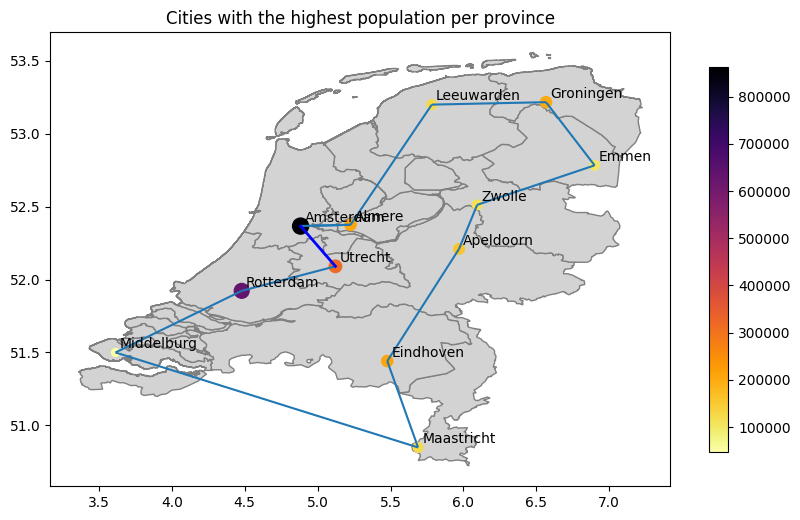

In [30]:
fig, ax = plt.subplots(figsize = (10, 10))

mapnl.plot(column = "NAME_1", edgecolor="grey", ax = ax, color = 'lightgrey')

geo_nl_cities_max['marker_size'] = np.sqrt(geo_nl_cities_max['population_proper']) / 7

geo_nl_cities_max.plot(column = 'population_proper', cmap = "inferno_r", ax = ax, legend = True, legend_kwds={'shrink': 0.5}, 
            markersize = 'marker_size')

for x, y, label in zip(geo_nl_cities_max.geometry.x, geo_nl_cities_max.geometry.y, geo_nl_cities_max.city):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")

lines.plot(ax = ax)

ax.plot((geo_nl_cities_max.iloc[11]["lng"], geo_nl_cities_max.iloc[0]["lng"]), (geo_nl_cities_max.iloc[11]["lat"], geo_nl_cities_max.iloc[0]["lat"]), linewidth = 2, linestyle = "-", color = "blue")

ax.set_title('Cities with the highest population per province')

In [36]:
# Create another instance, this time with the top 10 cities in the Netherlands by population (regardless of their pr)

geo_nl_max = geo_nl_cities.sort_values(['population_proper'], ascending = False).head(10)

geo_nl_max = geo_nl_max.reset_index(drop = True)

geo_nl_max

,city,lat,lng,admin_name,capital,population,population_proper,geometry,marker_size
0,Amsterdam,52.3667,4.8833,Noord-Holland,primary,862965.0,862965.0,POINT (4.88330 52.36670),132.708442
1,Rotterdam,51.9225,4.4792,Zuid-Holland,minor,631155.0,631155.0,POINT (4.47920 51.92250),113.493235
2,The Hague,52.0767,4.2986,Zuid-Holland,primary,1406000.0,501725.0,POINT (4.29860 52.07670),101.189356
3,Utrecht,52.0908,5.1222,Utrecht,admin,640000.0,316448.0,POINT (5.12220 52.09080),80.362444
4,Eindhoven,51.4408,5.4778,Noord-Brabant,minor,398053.0,209620.0,POINT (5.47780 51.44080),65.406110
5,Almere,52.3758,5.2256,Flevoland,minor,207904.0,207904.0,POINT (5.22560 52.37580),65.137844
6,Groningen,53.2167,6.5667,Groningen,admin,201462.0,201462.0,POINT (6.56670 53.21670),64.120741
7,Breda,51.5875,4.7750,Noord-Brabant,minor,183873.0,183873.0,POINT (4.77500 51.58750),61.257736
8,Apeldoorn,52.2100,5.9700,Gelderland,minor,161156.0,161156.0,POINT (5.97000 52.21000),57.348914
9,Haarlem,52.3803,4.6406,Noord-Holland,admin,159134.0,159134.0,POINT (4.64060 52.38030),56.988004


In [45]:
# Sort cities manually so we get a nice cycle (just for visualization purposes)

sort_dict = {"Amsterdam": 0,
             "Almere": 1,
             "Groningen": 2,
             "Apeldoorn": 3,
             "Eindhoven": 4,
             "Breda": 5,
             "Rotterdam": 6,
             "Maastricht": 7,
             "The Hague": 8,
             "Rotterdam": 9,}

geo_nl_max = geo_nl_max.sort_values(by = 'city', key = (lambda x: x.map(sort_dict)))

geo_nl_max = geo_nl_max.reset_index(drop = True)

geo_nl_max

,city,lat,lng,admin_name,capital,population,population_proper,geometry,marker_size,destination_coord
0,Amsterdam,52.3667,4.8833,Noord-Holland,primary,862965.0,862965.0,POINT (4.88330 52.36670),132.708442,POINT (4.4792 51.9225)
1,Almere,52.3758,5.2256,Flevoland,minor,207904.0,207904.0,POINT (5.22560 52.37580),65.137844,POINT (5.4778 51.4408)
2,Groningen,53.2167,6.5667,Groningen,admin,201462.0,201462.0,POINT (6.56670 53.21670),64.120741,POINT (5.2256 52.3758)
3,Apeldoorn,52.2100,5.9700,Gelderland,minor,161156.0,161156.0,POINT (5.97000 52.21000),57.348914,POINT (4.775 51.5875)
4,Eindhoven,51.4408,5.4778,Noord-Brabant,minor,398053.0,209620.0,POINT (5.47780 51.44080),65.406110,POINT (5.1222 52.0908)
5,Breda,51.5875,4.7750,Noord-Brabant,minor,183873.0,183873.0,POINT (4.77500 51.58750),61.257736,POINT (6.5667 53.2167)
6,The Hague,52.0767,4.2986,Zuid-Holland,primary,1406000.0,501725.0,POINT (4.29860 52.07670),101.189356,POINT (4.4792 51.9225)
7,Rotterdam,51.9225,4.4792,Zuid-Holland,minor,631155.0,631155.0,POINT (4.47920 51.92250),113.493235,POINT (4.8833 52.3667)
8,Utrecht,52.0908,5.1222,Utrecht,admin,640000.0,316448.0,POINT (5.12220 52.09080),80.362444,POINT (4.2986 52.0767)
9,Haarlem,52.3803,4.6406,Noord-Holland,admin,159134.0,159134.0,POINT (4.64060 52.38030),56.988004,POINT (5.97 52.21)


In [46]:
geo_nl_max["destination_coord"] = np.nan

geo_nl_max["destination_coord"][0] = geo_nl_max["geometry"][1]

for i in range(1, 10):
    geo_nl_max["destination_coord"][i] = geo_nl_max["geometry"][i-1]
    
geo_nl_max

/scratch-local/nskor/ipykernel_3742577/1962002643.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geo_nl_max["destination_coord"][0] = geo_nl_max["geometry"][1]


,city,lat,lng,admin_name,capital,population,population_proper,geometry,marker_size,destination_coord
0,Amsterdam,52.3667,4.8833,Noord-Holland,primary,862965.0,862965.0,POINT (4.88330 52.36670),132.708442,POINT (5.2256 52.3758)
1,Almere,52.3758,5.2256,Flevoland,minor,207904.0,207904.0,POINT (5.22560 52.37580),65.137844,POINT (4.8833 52.3667)
2,Groningen,53.2167,6.5667,Groningen,admin,201462.0,201462.0,POINT (6.56670 53.21670),64.120741,POINT (5.2256 52.3758)
3,Apeldoorn,52.2100,5.9700,Gelderland,minor,161156.0,161156.0,POINT (5.97000 52.21000),57.348914,POINT (6.5667 53.2167)
4,Eindhoven,51.4408,5.4778,Noord-Brabant,minor,398053.0,209620.0,POINT (5.47780 51.44080),65.406110,POINT (5.97 52.21)
5,Breda,51.5875,4.7750,Noord-Brabant,minor,183873.0,183873.0,POINT (4.77500 51.58750),61.257736,POINT (5.4778 51.4408)
6,The Hague,52.0767,4.2986,Zuid-Holland,primary,1406000.0,501725.0,POINT (4.29860 52.07670),101.189356,POINT (4.775 51.5875)
7,Rotterdam,51.9225,4.4792,Zuid-Holland,minor,631155.0,631155.0,POINT (4.47920 51.92250),113.493235,POINT (4.2986 52.0767)
8,Utrecht,52.0908,5.1222,Utrecht,admin,640000.0,316448.0,POINT (5.12220 52.09080),80.362444,POINT (4.4792 51.9225)
9,Haarlem,52.3803,4.6406,Noord-Holland,admin,159134.0,159134.0,POINT (4.64060 52.38030),56.988004,POINT (5.1222 52.0908)


In [47]:
# Create geometry linestring between each point

lines = []

for i in range(0, 10):
    lines.append(LineString([geo_nl_max["geometry"][i], geo_nl_max["destination_coord"][i]]))

lines = gpd.GeoDataFrame(geometry = lines)

lines

,geometry
0,"LINESTRING (4.88330 52.36670, 5.22560 52.37580)"
1,"LINESTRING (5.22560 52.37580, 4.88330 52.36670)"
2,"LINESTRING (6.56670 53.21670, 5.22560 52.37580)"
3,"LINESTRING (5.97000 52.21000, 6.56670 53.21670)"
4,"LINESTRING (5.47780 51.44080, 5.97000 52.21000)"
5,"LINESTRING (4.77500 51.58750, 5.47780 51.44080)"
6,"LINESTRING (4.29860 52.07670, 4.77500 51.58750)"
7,"LINESTRING (4.47920 51.92250, 4.29860 52.07670)"
8,"LINESTRING (5.12220 52.09080, 4.47920 51.92250)"
9,"LINESTRING (4.64060 52.38030, 5.12220 52.09080)"


/home/nskor/Hardness-of-ATSP/.venv/lib/python3.10/site-packages/geopandas/plotting.py:656: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


Text(0.5, 1.0, 'Top 10 Dutch Cities with the highest population')

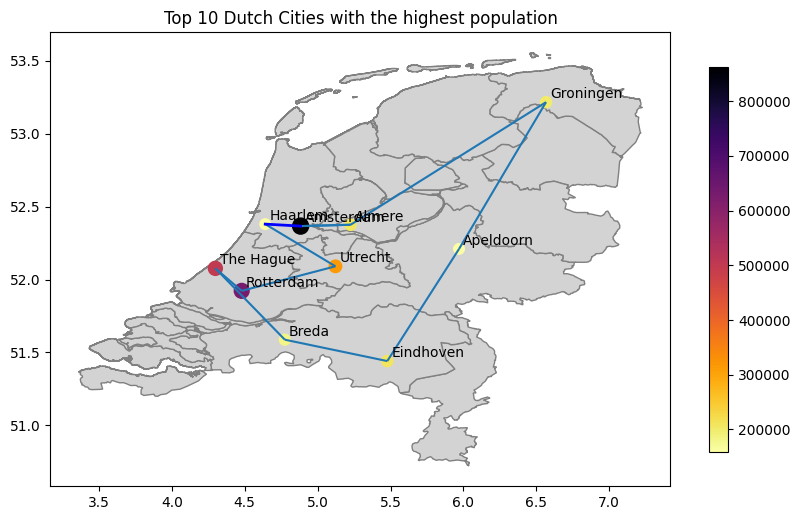

In [48]:
fig, ax = plt.subplots(figsize = (10, 10))

mapnl.plot(column = "NAME_1", edgecolor="grey", ax = ax, color = 'lightgrey')

geo_nl_max['marker_size'] = np.sqrt(geo_nl_max['population_proper']) / 7

geo_nl_max.plot(column = 'population_proper', cmap = "inferno_r", ax = ax, legend = True, legend_kwds={'shrink': 0.5}, 
            markersize = 'marker_size')

for x, y, label in zip(geo_nl_max.geometry.x, geo_nl_max.geometry.y, geo_nl_max.city):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")

lines.plot(ax = ax)

ax.plot((geo_nl_max.iloc[9]["lng"], geo_nl_max.iloc[0]["lng"]), (geo_nl_max.iloc[9]["lat"], geo_nl_max.iloc[0]["lat"]), linewidth = 2, linestyle = "-", color = "blue")

ax.set_title('Top 10 Dutch Cities with the highest population')

In [ ]:
# To-do

# Find asymmetric TSP datasets - e.g. road distances, road time taken.

# https://www.besteroutes.com/afstandstabel/nl/